In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import numpy as np

In [3]:
import lal
import lalsimulation as lalsim

In [4]:
def compute_L_to_J_angles(mass1, mass2, f_ref, inc, phiref, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z):
    # get the three angles that define the initially J-aligned frame:
    #   - thetaJN is the polar angle between J and zhat
    #   - phi_aligned is the negative of the azimuthal angle of J in the x-y plane
    #   - the final angle is "kappa" internally in the lal function, which is not output.
    #       As we are always calculating the angles with zero inclination, kappa is always pi.
    _, _, _, thetaJN, alpha, phi_aligned, _ = lalsim.SimIMRPhenomPCalculateModelParametersFromSourceFrame(
        mass1*lal.MSUN_SI, mass2*lal.MSUN_SI,
        f_ref, inc, phiref,
        spin1x, spin1y, spin1z,
        spin2x, spin2y, spin2z,
        lalsim.IMRPhenomPv2_V)
    
    return thetaJN, alpha, phi_aligned

# functions from nrutils

In [5]:

# Calculate Widger D-Matrix Element
def wdelement( ll,         # polar index (eigenvalue) of multipole to be rotated (set of m's for single ll )
               mp,         # member of {all em for |em|<=l} -- potential projection spaceof m
               mm,         # member of {all em for |em|<=l} -- the starting space of m
               alpha,      # -.
               beta,       #  |- Euler angles for rotation
               gamma ):    # -'

    #** James Healy 6/18/2012
    #** wignerDelement
    #*  calculates an element of the wignerD matrix
    # Modified by llondon6 in 2012 and 2014
    # Converted to python by spxll 2016
    #
    # This implementation apparently uses the formula given in:
    # https://en.wikipedia.org/wiki/Wigner_D-matrix
    #
    # Specifically, this the formula located here: https://wikimedia.org/api/rest_v1/media/math/render/svg/53fd7befce1972763f7f53f5bcf4dd158c324b55

    #
    from numpy import sqrt,exp,cos,sin,ndarray
    from scipy.special import factorial

    #
    if ( (type(alpha) is ndarray) and (type(beta) is ndarray) and (type(gamma) is ndarray) ):
        alpha,beta,gamma = alpha.astype(float), beta.astype(float), gamma.astype(float)
    else:
        alpha,beta,gamma = float(alpha),float(beta),float(gamma)

    #
    coefficient = sqrt( factorial(ll+mp)*factorial(ll-mp)*factorial(ll+mm)*factorial(ll-mm))*exp( 1j*(mp*alpha+mm*gamma) )

    # NOTE that there may be convention differences where the overall sign of the complex exponential may be negated

    #
    total = 0

    # find smin
    if (mm-mp) >= 0 :
        smin = mm - mp
    else:
        smin = 0

    # find smax
    if (ll+mm) > (ll-mp) :
        smax = ll-mp
    else:
        smax = ll+mm

    #
    if smin <= smax:
        for ss in range(smin,smax+1):
            A = (-1)**(mp-mm+ss)
            A *= cos(beta/2)**(2*ll+mm-mp-2*ss)  *  sin(beta/2)**(mp-mm+2*ss)
            B = factorial(ll+mm-ss) * factorial(ss) * factorial(mp-mm+ss) * factorial(ll-mp-ss)
            total += A/B

    #
    element = coefficient*total
    return element

In [6]:
# Given dictionary of multipoles all with the same l, calculate the roated multipole with (l,mp)
def rotate_wfarrs_at_all_times( l,                          # the l of the new multipole (everything should have the same l)
                                m,                          # the m of the new multipole
                                like_l_multipoles_dict,     # dictionary in the format { (l,m): array([domain_values,+,x]) }
                                euler_alpha_beta_gamma,
                                ref_orientation = None ):             #

    '''
    Given dictionary of multipoles all with the same l, calculate the roated multipole with (l,mp).
    Key reference -- arxiv:1012:2879
    ~ LL,EZH 2018
    '''

    # Import usefuls
    from numpy import exp, pi, array, ones, sign, complex128
#     from nrutils.manipulate.rotate import wdelement

    #
    alpha,beta,gamma = euler_alpha_beta_gamma

    #
    if not ( ref_orientation is None ) :
        error('The use of "ref_orientation" has been depreciated for this function.')

    # Handle the default behavior for the reference orientation
    if ref_orientation is None:
        ref_orientation = ones(3)

    # Apply the desired offecrt for the reference orientation. NOTE that this is primarily useful for BAM run which have an atypical coordinate setup if Jz<0
    gamma *= sign( ref_orientation[-1] )
    alpha *= sign( ref_orientation[-1] )

    # Test to see if the original wfarr is complex and if so set the new wfarr to be complex as well
    wfarr_type = type( like_l_multipoles_dict[list(like_l_multipoles_dict.keys())[0]][:,1][0] )

    #
    # new_ylm = 0
    if wfarr_type == complex128:
        new_plus  = 0 + 0j
        new_cross = 0 + 0j
    else:
        new_plus  = 0
        new_cross = 0
    for lm in like_l_multipoles_dict:
        # See eq A9 of arxiv:1012:2879
        l,mp = lm
        old_wfarr = like_l_multipoles_dict[lm]

        #
        # y_mp = old_wfarr[:,1] + 1j*old_wfarr[:,2]
        # new_ylm += wdelement(l,m,mp,alpha,beta,gamma) * y_mp

        #
        d = wdelement(l,m,mp,alpha,beta,gamma)
        a,b = d.real,d.imag
        #
        p = old_wfarr[:,1]
        c = old_wfarr[:,2]
        #
        new_plus  += a*p - b*c
        new_cross += b*p + a*c

    # Construct the new waveform array
    t = old_wfarr[:,0]

    #
    # ans = array( [ t, new_ylm.real, new_ylm.imag ] ).T
    ans = array( [ t, new_plus, new_cross ] ).T

    # Return the answer
    return ans

In [7]:
def convert_to_nrutils_dict(times, hlms):
    hlms_3col = {}
    for k in hlms.keys():
        hlms_3col[k] = np.array([times, np.real(hlms[k]), np.imag(hlms[k])]).T
    return hlms_3col

# begin

In [8]:
import scri
import quaternion

In [9]:
from scrinet.interfaces import lalutils

In [185]:
# params = lalutils.gen_td_modes_wf_params(m2=5, approximant=lalsim.SEOBNRv4PHM)
params = lalutils.gen_td_modes_wf_params(m1=30, m2=30, approximant=lalsim.SEOBNRv4PHM, S1x=0.5, S1y=0.5, S2x=0.5, S2y=0.5, f_min=14, f_ref=14, phiRef=0.)
# params = lalutils.gen_td_modes_wf_params(m2=30, approximant=lalsim.NRSur7dq4, S1x=0.5, S1y=0., f_min=14, f_ref=14)

In [186]:
params

{'m1': 30,
 'm2': 30,
 'S1x': 0.5,
 'S1y': 0.5,
 'S1z': 0,
 'S2x': 0.5,
 'S2y': 0.5,
 'S2z': 0,
 'phiRef': 0.0,
 'r': 1,
 'deltaT': 0.000244140625,
 'f_min': 14,
 'f_ref': 14,
 'LALpars': None,
 'lmax': 2,
 'approximant': 52}

In [187]:
times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]])
# times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=False, modes=[[2,2],[2,1],[2,0],[2,-1],[2,-2]])

In [188]:
hlms

{(2,
  2): array([7241.32090049-1268.01371497j, 7212.5068589 -1423.26553009j,
        7180.36495975-1577.86219197j, ...,    0.           -0.j        ,
           0.           -0.j        ,    0.           -0.j        ]),
 (2,
  1): array([-13.9949871 -79.91713283j, -15.02232715-80.62381025j,
        -16.08612691-81.32249921j, ...,   0.         -0.j        ,
          0.         -0.j        ,   0.         -0.j        ]),
 (2,
  0): array([-1.08027438-0.j, -1.10372889-0.j, -1.12758344-0.j, ...,
         0.        -0.j,  0.        -0.j,  0.        -0.j]),
 (2,
  -1): array([13.9949871 -79.91713283j, 15.02232715-80.62381025j,
        16.08612691-81.32249921j, ...,  0.         -0.j        ,
         0.         -0.j        ,  0.         -0.j        ]),
 (2,
  -2): array([7241.32090049+1268.01371497j, 7212.5068589 +1423.26553009j,
        7180.36495975+1577.86219197j, ...,    0.           -0.j        ,
           0.           -0.j        ,    0.           -0.j        ])}

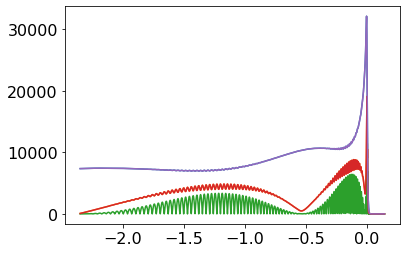

In [189]:
plt.figure()
plt.plot(times, np.abs(hlms[(2,2)]))
plt.plot(times, np.abs(hlms[(2,1)]))
plt.plot(times, np.abs(hlms[(2,0)]))
plt.plot(times, np.abs(hlms[(2,-1)]))
plt.plot(times, np.abs(hlms[(2,-2)]))

In [190]:
thetaJN, alpha, phi_aligned = compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha, phi_aligned)

0.29514083659978924 1.2246467991473532e-16 -0.7853981633974483


In [191]:
# # save data to try with NRutils
# import h5py
# with h5py.File('h2m.h5', "w") as f:
#     f.create_dataset("2,2", data=hlms[(2,2)])
#     f.create_dataset("2,1", data=hlms[(2,1)])
#     f.create_dataset("2,0", data=hlms[(2,0)])
#     f.create_dataset("2,-1", data=hlms[(2,-1)])
#     f.create_dataset("2,-2", data=hlms[(2,-2)])
#     f.create_dataset("t", data=times)

In [192]:
hlms_3col = convert_to_nrutils_dict(times, hlms)

In [193]:
hlms_3col_j = {}
hlms_j = {}
for k in hlms_3col.keys():
    l,m=k
    hlms_3col_j[k] = rotate_wfarrs_at_all_times(l,m,hlms_3col,[-alpha,-thetaJN,-phi_aligned])
    hlms_j[k] = hlms_3col_j[k][:,1] + 1.j * hlms_3col_j[k][:,2]

In [210]:
hlms_j.keys()

dict_keys([(2, 2), (2, 1), (2, 0), (2, -1), (2, -2)])

In [213]:
hlms_j[(2, -1)]

array([314.52712669-2169.85090502j, 357.92969147-2162.64275107j,
       401.17617628-2154.48586959j, ...,   0.           +0.j        ,
         0.           +0.j        ,   0.           +0.j        ])

In [194]:
# del w
# compute co-precessing frame using scri
ell_min=2
ell_max=2
w = scri.WaveformModes()
w.ells = ell_min, ell_max
n_times = len(times)
n_modes = len(hlms_j.keys())
w.t = times
w.data = np.zeros((n_times, n_modes), dtype=complex)

# specific for scri
mode_list = [(2,-2), (2,-1), (2,0), (2,1), (2,2)]

for i, lm in enumerate(mode_list):
    w.data[:,i] = hlms_j[lm]

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/scri/waveform_modes.py:263: UserWarning: 
Waveform's data.shape=(0, 0) does not agree with (ell_min,ell_max)=(2,2).
Hopefully you are about to reset `data`.  To avoid this warning,
reset `data` before resetting ell_min and/or ell_max.
  warnings.warn(warning)


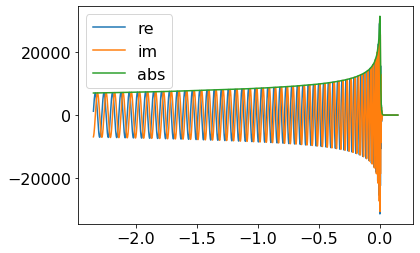

In [195]:
plt.figure()
plt.plot(w[:,2].t, w[:,2].data[:,0].real, label='re')
plt.plot(w[:,2].t, w[:,2].data[:,0].imag, label='im')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='abs')
plt.legend()
# plt.xlim(-0.1,0.1)

In [196]:
w


WaveformModes(
    t=[-2.347606 -2.347362 -2.347117 ...  0.145803  0.146047  0.146291],
    frame=[],
    data=[[1227.288231-6.908899e+03j  314.527127-2.169851e+03j   98.676381+0.000000e+00j -314.527127-2.169851e+03j 1227.288231+6.908899e+03j]
          [1375.907954-6.880974e+03j  357.929691-2.162643e+03j  114.898169+5.684342e-14j -357.929691-2.162643e+03j 1375.907954+6.880974e+03j]
          [1523.891471-6.849860e+03j  401.176176-2.154486e+03j  131.073144-5.684342e-14j -401.176176-2.154486e+03j 1523.891471+6.849860e+03j]
          ...
          [   0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j]
          [   0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j]
          [   0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j    0.      +0.000000e+00j]],
    frameType=0, dataType=0,


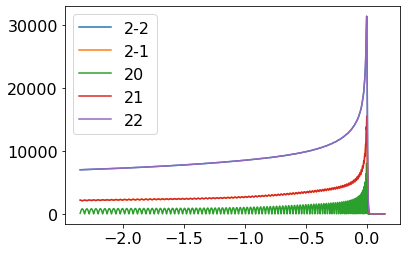

In [197]:
plt.figure()
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='2-2')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,1]), label='2-1')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,2]), label='20')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,3]), label='21')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,4]), label='22')
plt.legend()

In [198]:
w.to_coprecessing_frame()


WaveformModes(
    t=[-2.347606 -2.347362 -2.347117 ...  0.145803  0.146047  0.146291],
    frame=[quaternion(0.988542610516631, 0.00394713257794618, -0.150890448131669, 0)
           quaternion(0.988542283123969, 0.00403004488840934, -0.150890400801631, 1.26558651849512e-05)
           quaternion(0.98854195573745, 0.00411296384570836, -0.150890306628483, 2.53129382094466e-05) ...
           quaternion(0.430005300513111, 0, 0, 0.902826362890799) quaternion(0.430005300513111, 0, 0, 0.902826362890799)
           quaternion(0.430005300513111, 0, 0, 0.902826362890799)],
    data=[[ 1.284899e+03-7.238799e+03j  6.998846e-13-4.973799e-14j -1.847411e-13+0.000000e+00j -6.821210e-13+0.000000e+00j  1.284899e+03+7.238799e+03j]
          [ 1.440086e+03-7.209634e+03j -1.482370e-12-7.105427e-14j -3.694822e-13+5.684342e-14j  1.421085e-12+4.547474e-13j  1.440086e+03+7.209634e+03j]
          [ 1.594610e+03-7.177143e+03j  7.887024e-13+8.810730e-13j -8.714629e-09+1.136868e-13j -7.958079e-13+1.136868e-12j

(-0.1, 0.1)

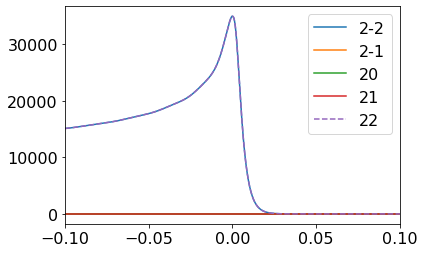

In [199]:
plt.figure()
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='2-2')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,1]), label='2-1')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,2]), label='20')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,3]), label='21')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,4]), label='22', ls='--')
plt.legend()
plt.xlim(-0.1,0.1)

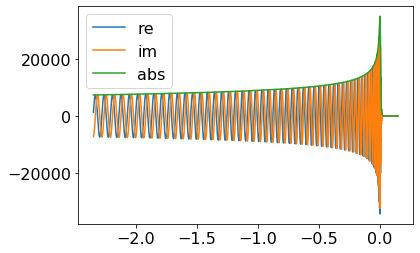

In [200]:
plt.figure()
plt.plot(w[:,2].t, w[:,2].data[:,0].real, label='re')
plt.plot(w[:,2].t, w[:,2].data[:,0].imag, label='im')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='abs')
plt.legend()
# plt.xlim(-0.4,0.2)

(-0.1, 0.1)

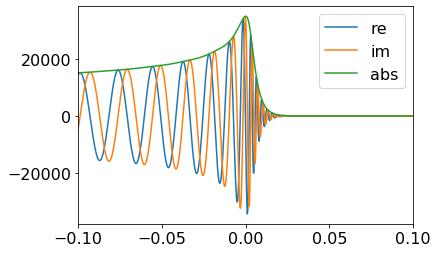

In [201]:
plt.figure()
plt.plot(w[:,2].t, w[:,2].data[:,0].real, label='re')
plt.plot(w[:,2].t, w[:,2].data[:,0].imag, label='im')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='abs')
plt.legend()
plt.xlim(-0.1,0.1)

In [202]:
w.frame.shape

(10216,)

In [203]:
eulers = np.array([quaternion.as_euler_angles(w.frame[tt]) for tt in range(len(w[:,2].t))])
if len(eulers.shape)==3:
    eulers = eulers.reshape(eulers.shape[0], eulers.shape[2])

In [204]:
eulers.shape

(10216, 3)

In [205]:
 try:
    ww=np.array([w.frame[tt][0].w for tt in range(len(w[:,2].t))])
    xx=np.array([w.frame[tt][0].x for tt in range(len(w[:,2].t))])
    yy=np.array([w.frame[tt][0].y for tt in range(len(w[:,2].t))])
    zz=np.array([w.frame[tt][0].z for tt in range(len(w[:,2].t))])
except:
    ww=np.array([w.frame[tt].w for tt in range(len(w[:,2].t))])
    xx=np.array([w.frame[tt].x for tt in range(len(w[:,2].t))])
    yy=np.array([w.frame[tt].y for tt in range(len(w[:,2].t))])
    zz=np.array([w.frame[tt].z for tt in range(len(w[:,2].t))])

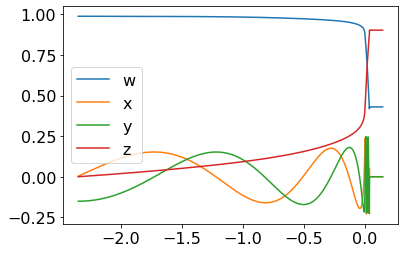

In [206]:
plt.figure()
plt.plot(w[:,2].t, ww, label='w')
plt.plot(w[:,2].t, xx, label='x')
plt.plot(w[:,2].t, yy, label='y')
plt.plot(w[:,2].t, zz, label='z')
plt.legend()
# plt.xlim(-0.1,0.1)

(-0.1, 0.1)

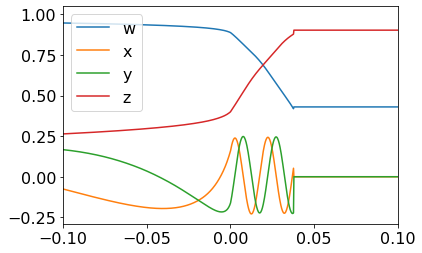

In [207]:
plt.figure()
plt.plot(w[:,2].t, ww, label='w')
plt.plot(w[:,2].t, xx, label='x')
plt.plot(w[:,2].t, yy, label='y')
plt.plot(w[:,2].t, zz, label='z')
plt.legend()
plt.xlim(-0.1,0.1)

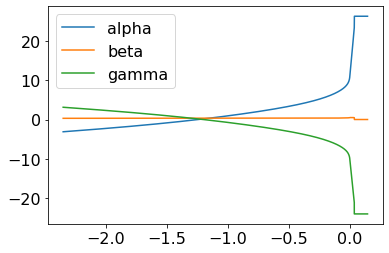

In [208]:
plt.figure()
plt.plot(w[:,2].t, np.unwrap(eulers[:,0]), label='alpha')
plt.plot(w[:,2].t, eulers[:,1], label='beta')
plt.plot(w[:,2].t, np.unwrap(eulers[:,2]), label='gamma')
plt.legend()
# plt.xlim(-0.1,0.1)

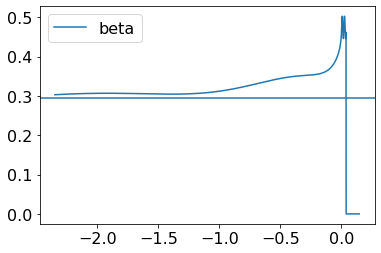

In [209]:
plt.figure()
plt.plot(w[:,2].t, eulers[:,1], label='beta')
plt.legend()
# plt.xlim(-0.1,0.1)
plt.axhline(thetaJN)

In [45]:
# eob_t = w[:,2].t
# eob_a = np.unwrap(eulers[:,0])
# eob_b = eulers[:,1]
# eob_g = np.unwrap(eulers[:,2])

# np.savetxt('eob-angles.txt',np.array([eob_t,eob_a,eob_b,eob_g]).T)



NameError: name 'eob_t' is not defined

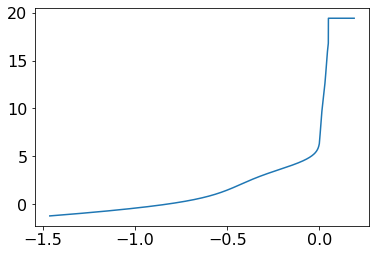

In [46]:
plt.figure()
plt.plot(w[:,2].t, np.unwrap(eulers[:,0]), label='alpha')
plt.plot(eob_t, eob_a, label='eob alpha')
plt.legend()
# plt.xlim(-0.1,0.1)

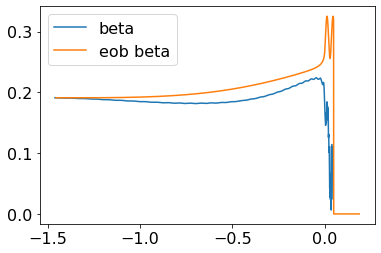

In [277]:
plt.figure()
plt.plot(w[:,2].t, eulers[:,1], label='beta')
plt.plot(eob_t, eob_b, label='eob beta')
plt.legend()
# plt.xlim(-0.1,0.1)

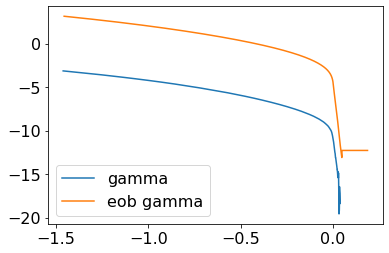

In [275]:
plt.figure()
plt.plot(w[:,2].t, np.unwrap(eulers[:,2]), label='gamma')
plt.plot(eob_t, eob_g, label='eob gamma')
plt.legend()
# plt.xlim(-0.1,0.1)

# load J aligned modes from HAWK as made by NRutils

In [211]:
ls

coprec-scri.ipynb  eob-angles.txt     h2m.h5             hawk_h2m.h5


In [540]:
hlms_hawk = {}

with h5py.File("hawk_h2m.h5", "r") as f:
    times_hawk = f['t'][:]
    hlms_hawk[(2,2)] = f['2,2'][:]
    hlms_hawk[(2,1)] = f['2,1'][:]
    hlms_hawk[(2,0)] = f['2,0'][:]
    hlms_hawk[(2,-1)] = f['2,-1'][:]
    hlms_hawk[(2,-2)] = f['2,-2'][:]

In [541]:
# del w
# compute co-precessing frame using scri
ell_min=2
ell_max=2
w2 = scri.WaveformModes()
w2.ells = ell_min, ell_max
n_times = len(times_hawk)
n_modes = len(hlms_hawk.keys())
w2.t = times_hawk
w2.data = np.zeros((n_times, n_modes), dtype=complex)

# specific for scri
mode_list = [(2,-2), (2,-1), (2,0), (2,1), (2,2)]

for i, lm in enumerate(mode_list):
    w2.data[:,i] = hlms_hawk[lm][:,1] + 1.j * hlms_hawk[lm][:,2]

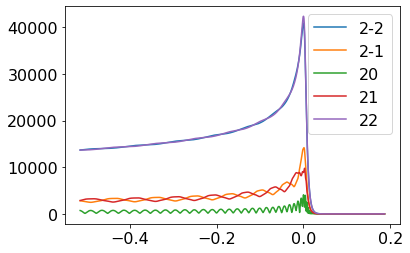

In [542]:
plt.figure()
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,0]), label='2-2')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,1]), label='2-1')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,2]), label='20')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,3]), label='21')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,4]), label='22')
plt.legend()

In [543]:
w2.to_coprecessing_frame()


WaveformModes(
    t=[-0.514783 -0.514539 -0.514295 ...  0.186389  0.186633  0.186877],
    frame=[quaternion(0.994599467658407, -1.33120054526503e-09, -0.103787759074048, 0)
           quaternion(0.994599467601581, 0.000102923292794986, -0.103787708029864, 1.07403211037219e-05)
           quaternion(0.994599467430587, 0.000205879743221787, -0.103787554835648, 2.14839742621386e-05) ...
           quaternion(0.964782857389489, 0, 0, 0.263047596619648) quaternion(0.964782857389489, 0, 0, 0.263047596619648)
           quaternion(0.964782857389489, 0, 0, 0.263047596619648)],
    data=[[ 1.345651e+04+3.788345e+03j  7.418506e+01-3.670896e+02j  6.252776e-13+2.700062e-13j  7.418506e+01+3.670896e+02j  1.345651e+04-3.788345e+03j]
          [ 1.333546e+04+4.200141e+03j  7.982876e+01-3.659767e+02j  3.581135e-12+1.421085e-14j  7.982876e+01+3.659767e+02j  1.333546e+04-4.200141e+03j]
          [ 1.320163e+04+4.608052e+03j  8.545427e+01-3.647694e+02j -2.160050e-12-1.989520e-13j  8.545427e+01+3.647694

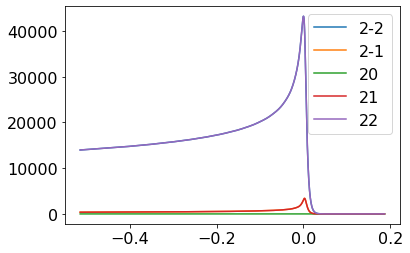

In [544]:
plt.figure()
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,0]), label='2-2')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,1]), label='2-1')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,2]), label='20')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,3]), label='21')
plt.plot(w2[:,2].t, np.abs(w2[:,2].data[:,4]), label='22')
plt.legend()

In [545]:
eulers = np.array([quaternion.as_euler_angles(w2.frame[tt]) for tt in range(len(w2[:,2].t))])
if len(eulers.shape)==3:
    eulers = eulers.reshape(eulers.shape[0], eulers.shape[2])

In [546]:
eulers.shape

(2875, 3)

In [547]:
 try:
    ww=np.array([w2.frame[tt][0].w for tt in range(len(w2[:,2].t))])
    xx=np.array([w2.frame[tt][0].x for tt in range(len(w2[:,2].t))])
    yy=np.array([w2.frame[tt][0].y for tt in range(len(w2[:,2].t))])
    zz=np.array([w2.frame[tt][0].z for tt in range(len(w2[:,2].t))])
except:
    ww=np.array([w2.frame[tt].w for tt in range(len(w2[:,2].t))])
    xx=np.array([w2.frame[tt].x for tt in range(len(w2[:,2].t))])
    yy=np.array([w2.frame[tt].y for tt in range(len(w2[:,2].t))])
    zz=np.array([w2.frame[tt].z for tt in range(len(w2[:,2].t))])

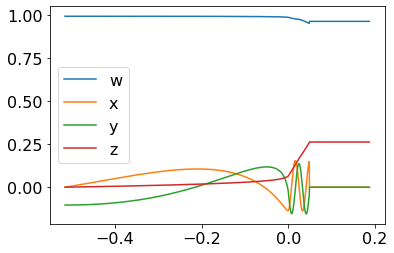

In [548]:
plt.figure()
plt.plot(w2[:,2].t, ww, label='w')
plt.plot(w2[:,2].t, xx, label='x')
plt.plot(w2[:,2].t, yy, label='y')
plt.plot(w2[:,2].t, zz, label='z')
plt.legend()
# plt.xlim(-0.1,0.1)

(-0.1, 0.1)

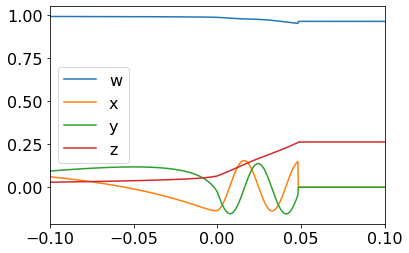

In [549]:
plt.figure()
plt.plot(w2[:,2].t, ww, label='w')
plt.plot(w2[:,2].t, xx, label='x')
plt.plot(w2[:,2].t, yy, label='y')
plt.plot(w2[:,2].t, zz, label='z')
plt.legend()
plt.xlim(-0.1,0.1)

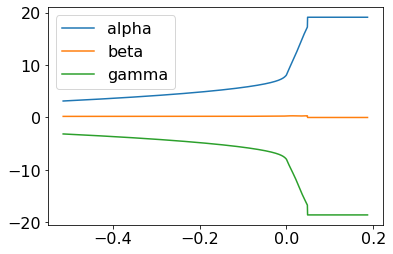

In [552]:
plt.figure()
plt.plot(w2[:,2].t, np.unwrap(eulers[:,0]), label='alpha')
plt.plot(w2[:,2].t, eulers[:,1], label='beta')
plt.plot(w2[:,2].t, np.unwrap(eulers[:,2]), label='gamma')
plt.legend()
# plt.xlim(-0.1,0.1)

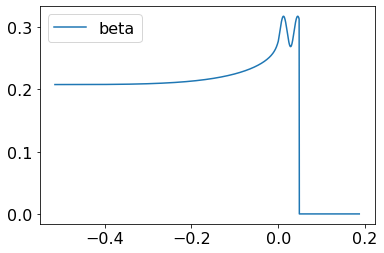

In [553]:
plt.figure()
plt.plot(w2[:,2].t, eulers[:,1], label='beta')
plt.legend()
# plt.xlim(-0.1,0.1)

# rotate wf from NRutils

In [28]:
import h5py
# hlms = {}
hlms_nrutils = {}
with h5py.File("h2m.h5", "r") as f:
    times = f['t'][:]
#     hlms[(2,2)] = f['2,2'][:]
#     hlms[(2,1)] = f['2,1'][:]
#     hlms[(2,0)] = f['2,0'][:]
#     hlms[(2,-1)] = f['2,-1'][:]
#     hlms[(2,-2)] = f['2,-2'][:]
    
    hlms_nrutils[(2,2)] = np.array([times, np.real(f['2,2'][:]), np.imag(f['2,2'][:])]).T
    hlms_nrutils[(2,1)] = np.array([times, np.real(f['2,1'][:]), np.imag(f['2,1'][:])]).T
    hlms_nrutils[(2,0)] = np.array([times, np.real(f['2,0'][:]), np.imag(f['2,0'][:])]).T
    hlms_nrutils[(2,-1)] = np.array([times, np.real(f['2,-1'][:]), np.imag(f['2,-1'][:])]).T
    hlms_nrutils[(2,-2)] = np.array([times, np.real(f['2,-2'][:]), np.imag(f['2,-2'][:])]).T

In [29]:
thetaJN, alpha, phi_aligned = 0.20795, 0, 0

In [34]:
hlms_nrutils_rot_j = {}
for k in hlms_nrutils.keys():
    l,m=k
    hlms_nrutils_rot_j[k] = rotate_wfarrs_at_all_times(l,m,hlms_nrutils,[0,-thetaJN,0])

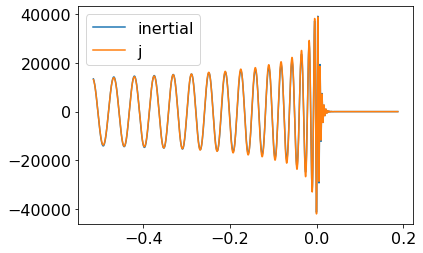

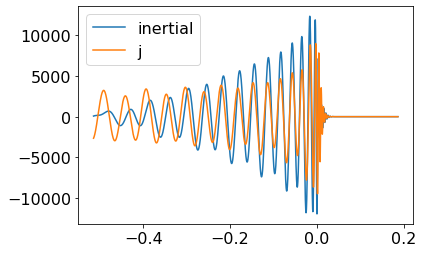

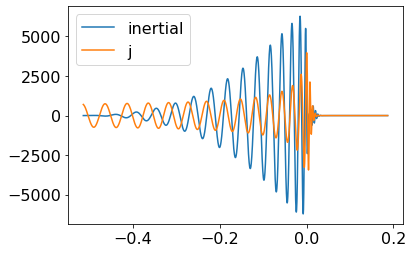

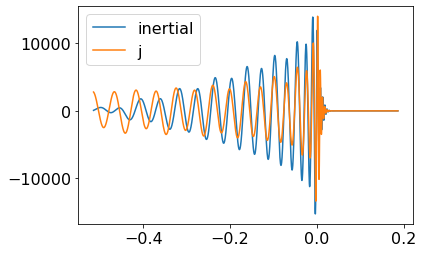

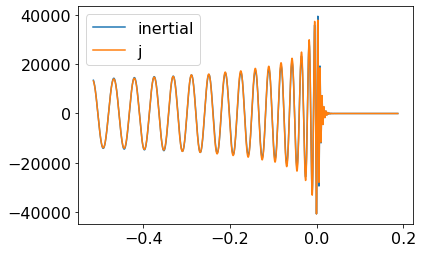

In [35]:
for k in hlms_nrutils.keys():
    plt.figure()
    plt.plot(hlms_nrutils[k][:,0], hlms_nrutils[k][:,1], label='inertial')
    plt.plot(hlms_nrutils_rot_j[k][:,0], hlms_nrutils_rot_j[k][:,1], label='j')
    plt.legend()

In [37]:
# del w
# compute co-precessing frame using scri
ell_min=2
ell_max=2
w = scri.WaveformModes()
w.ells = ell_min, ell_max
n_times = len(times)
n_modes = len(hlms_nrutils_rot_j.keys())
w.t = times
w.data = np.zeros((n_times, n_modes), dtype=complex)

# specific for scri
mode_list = [(2,-2), (2,-1), (2,0), (2,1), (2,2)]

for i, lm in enumerate(mode_list):
    w.data[:,i] = hlms_nrutils_rot_j[lm][:,1] + 1.j * hlms_nrutils_rot_j[lm][:,2]

In [38]:
w.to_coprecessing_frame()


WaveformModes(
    t=[-0.514783 -0.514539 -0.514295 ...  0.186389  0.186633  0.186877],
    frame=[quaternion(0.994599467658407, -1.33120048941479e-09, -0.103787759074048, 0)
           quaternion(0.994599467601581, 0.000102923292795042, -0.103787708029864, 1.07403211037251e-05)
           quaternion(0.994599467430587, 0.000205879743221787, -0.103787554835648, 2.14839742621328e-05) ...
           quaternion(0.964782857389489, 0, 0, 0.263047596619648) quaternion(0.964782857389489, 0, 0, 0.263047596619648)
           quaternion(0.964782857389489, 0, 0, 0.263047596619648)],
    data=[[ 1.345651e+04+3.788345e+03j  7.418506e+01-3.670896e+02j  5.115908e-13+3.268497e-13j  7.418506e+01+3.670896e+02j  1.345651e+04-3.788345e+03j]
          [ 1.333546e+04+4.200141e+03j  7.982876e+01-3.659767e+02j  3.240075e-12+2.842171e-14j  7.982876e+01+3.659767e+02j  1.333546e+04-4.200141e+03j]
          [ 1.320163e+04+4.608052e+03j  8.545427e+01-3.647694e+02j -2.216893e-12-2.415845e-13j  8.545427e+01+3.647694

(-0.1, 0.1)

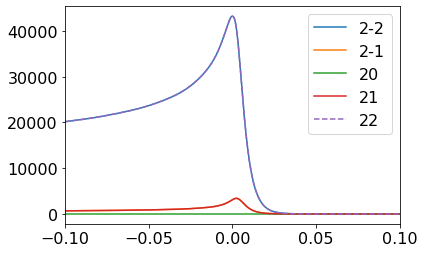

In [39]:
plt.figure()
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='2-2')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,1]), label='2-1')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,2]), label='20')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,3]), label='21')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,4]), label='22', ls='--')
plt.legend()
plt.xlim(-0.1,0.1)

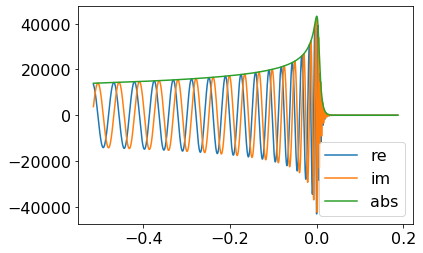

In [40]:
plt.figure()
plt.plot(w[:,2].t, w[:,2].data[:,0].real, label='re')
plt.plot(w[:,2].t, w[:,2].data[:,0].imag, label='im')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='abs')
plt.legend()
# plt.xlim(-0.4,0.2)

(-0.1, 0.1)

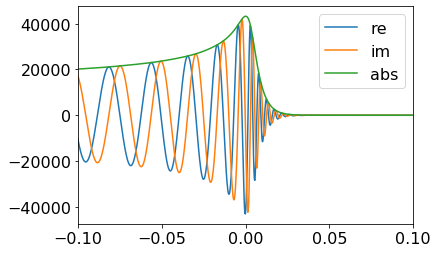

In [41]:
plt.figure()
plt.plot(w[:,2].t, w[:,2].data[:,0].real, label='re')
plt.plot(w[:,2].t, w[:,2].data[:,0].imag, label='im')
plt.plot(w[:,2].t, np.abs(w[:,2].data[:,0]), label='abs')
plt.legend()
plt.xlim(-0.1,0.1)

In [42]:
w.frame.shape

(2875,)

In [48]:
eulers = np.array([quaternion.as_euler_angles(w.frame[tt]) for tt in range(len(w[:,2].t))])
if len(eulers.shape)==3:
    eulers = eulers.reshape(eulers.shape[0], eulers.shape[2])

In [49]:
eulers.shape

(2875, 3)

In [50]:
 try:
    ww=np.array([w.frame[tt][0].w for tt in range(len(w[:,2].t))])
    xx=np.array([w.frame[tt][0].x for tt in range(len(w[:,2].t))])
    yy=np.array([w.frame[tt][0].y for tt in range(len(w[:,2].t))])
    zz=np.array([w.frame[tt][0].z for tt in range(len(w[:,2].t))])
except:
    ww=np.array([w.frame[tt].w for tt in range(len(w[:,2].t))])
    xx=np.array([w.frame[tt].x for tt in range(len(w[:,2].t))])
    yy=np.array([w.frame[tt].y for tt in range(len(w[:,2].t))])
    zz=np.array([w.frame[tt].z for tt in range(len(w[:,2].t))])

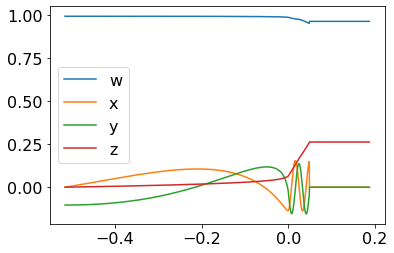

In [51]:
plt.figure()
plt.plot(w[:,2].t, ww, label='w')
plt.plot(w[:,2].t, xx, label='x')
plt.plot(w[:,2].t, yy, label='y')
plt.plot(w[:,2].t, zz, label='z')
plt.legend()
# plt.xlim(-0.1,0.1)

(-0.1, 0.1)

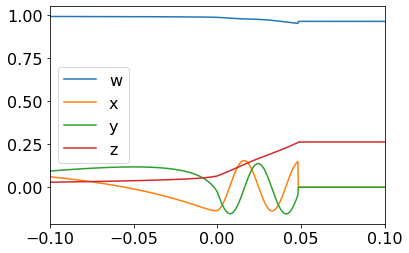

In [52]:
plt.figure()
plt.plot(w[:,2].t, ww, label='w')
plt.plot(w[:,2].t, xx, label='x')
plt.plot(w[:,2].t, yy, label='y')
plt.plot(w[:,2].t, zz, label='z')
plt.legend()
plt.xlim(-0.1,0.1)

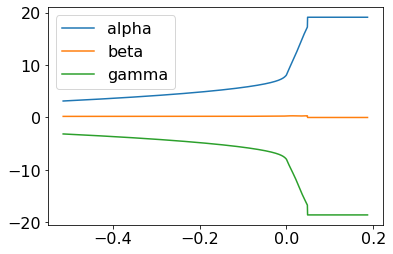

In [53]:
plt.figure()
plt.plot(w[:,2].t, np.unwrap(eulers[:,0]), label='alpha')
plt.plot(w[:,2].t, eulers[:,1], label='beta')
plt.plot(w[:,2].t, np.unwrap(eulers[:,2]), label='gamma')
plt.legend()
# plt.xlim(-0.1,0.1)

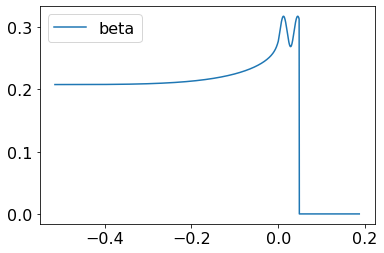

In [54]:
plt.figure()
plt.plot(w[:,2].t, eulers[:,1], label='beta')
plt.legend()
# plt.xlim(-0.1,0.1)

# test load data

In [214]:
ls /Users/spx8sk/work/git/stk/scrinet/bin/pipeline

scrinet_build_rb*
scrinet_combine_wf_data*
scrinet_evaluate_model*
scrinet_fit*
scrinet_gen_ts_data*
scrinet_gen_wf_data_2d_non_prec*
scrinet_gen_wf_data_3d_non_prec*
scrinet_gen_wf_data_3d_prec_single_spin*
scrinet_gen_wf_data_3d_prec_single_spin_coprec*
scrinet_gen_wf_data_non_spinning*
scrinet_make_webpage*
scrinet_make_workflow*
seed_wf_data/


In [215]:
from scrinet.workflow import pipe_utils

In [217]:
??pipe_utils.load_data

Signature: pipe_utils.load_data(data_to_model, dir_name)
Docstring: <no docstring>
Source:   
def load_data(data_to_model, dir_name):
    with h5py.File(os.path.join(dir_name, 'times.h5'), 'r') as f:
        x = f['times'][:]

    with h5py.File(os.path.join(dir_name, 'coords.h5'), 'r') as f:
        coords = f['data'][:]

    with h5py.File(os.path.join(dir_name, f'{data_to_model}.h5'), 'r') as f:
        data = f['data'][:]

    return x, data, coords
File:      ~/work/git/stk/scrinet/scrinet/workflow/pipe_utils.py
Type:      function


In [241]:
x, alpha, coords = pipe_utils.load_data("alpha", "/Users/spx8sk/work/git/stk/scrinet/bin/pipeline/seed_wf_data")
_, beta, _ = pipe_utils.load_data("beta", "/Users/spx8sk/work/git/stk/scrinet/bin/pipeline/seed_wf_data")
_, gamma, _ = pipe_utils.load_data("gamma", "/Users/spx8sk/work/git/stk/scrinet/bin/pipeline/seed_wf_data")
_, amp, _ = pipe_utils.load_data("amp", "/Users/spx8sk/work/git/stk/scrinet/bin/pipeline/seed_wf_data")

In [235]:
alpha.shape

(52, 5000)

In [236]:
coords

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.33333000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.66667000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  3.30000000e-01],
       [ 1.00000000e+00,  2.85790000e-01,  1.65000000e-01],
       [ 1.00000000e+00,  2.85790000e-01, -1.65000000e-01],
       [ 1.00000000e+00,  4.04133444e-17, -3.30000000e-01],
       [ 3.33333000e+00,  0.00000000e+00,  3.30000000e-01],
       [ 3.33333000e+00,  2.85790000e-01,  1.65000000e-01],
       [ 3.33333000e+00,  2.85790000e-01, -1.65000000e-01],
       [ 3.33333000e+00,  4.04133444e-17, -3.30000000e-01],
       [ 5.66667000e+00,  0.00000000e+00,  3.30000000e-01],
       [ 5.66667000e+00,  2.85790000e-01,  1.65000000e-01],
       [ 5.66667000e+00,  2.85790000e-01, -1.65000000e-01],
       [ 5.66667000e+00,  4.04133444e-17, -3.30000000e-01],
       [ 8.00000000e+00,  0.00000000e+00

(-100, 200)

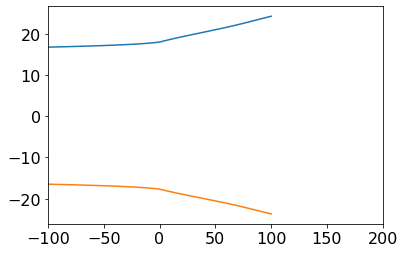

In [245]:
plt.figure()
plt.plot(x, alpha[9])
plt.plot(x, gamma[9])
plt.xlim(-100,200)

(-100, 200)

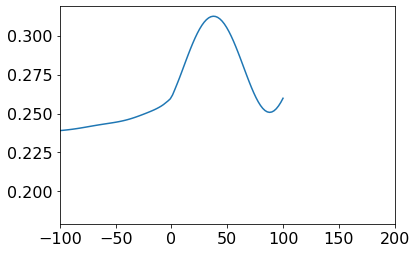

In [246]:
plt.figure()
plt.plot(x, beta[9])
plt.xlim(-100,200)

(-100, 200)

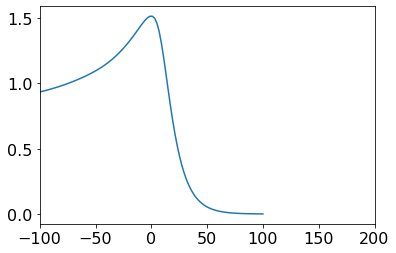

In [242]:
plt.figure()
# plt.plot(x, alpha[9])
plt.plot(x, amp[9])
# plt.plot(x, gamma[9])
plt.xlim(-100,200)